In [118]:
import jax
import jax.numpy as jnp
import haiku as hk

from clu import metrics
import flax
from flax import linen as nn
from flax.training import train_state
from flax import struct, core
import optax

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import json
import numpy as np

from typing import Callable, Any, List

import torch, torchvision
from torchvision import transforms

from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [89]:
def collate_fn(batch):
    return jnp.asarray(torch.stack([b[0] for b in batch], dim=0).permute(0, 2, 3, 1).cpu().numpy()), \
    jnp.array([b[1] for b in batch], dtype=jnp.int32)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 64
corruption = 0.3 # attention

np.random.seed(0)

trainset = torch.utils.data.Subset(torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform,
                                             target_transform=lambda y: torch.randint(0, 10, (1,)).item() \
                                             if np.random.rand() < corruption else y), torch.arange(1000))  # attention

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0, collate_fn=collate_fn,
                                         drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0, collate_fn=collate_fn)

# for outer optimization
valloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0, collate_fn=collate_fn)



In [90]:
class CNN(hk.Module):
    def __init__(self):
        super().__init__(name="CNN")
        self.conv1 = hk.Conv2D(output_channels=8, kernel_shape=(3,3), with_bias=False)
        self.bn1 = hk.BatchNorm(True, True, 0.9)
        self.conv2 = hk.Conv2D(output_channels=16, kernel_shape=(3,3), with_bias=False)
        self.bn2 = hk.BatchNorm(True, True, 0.9)
        self.conv3 = hk.Conv2D(output_channels=8, kernel_shape=(3,3), with_bias=False)
        self.bn3 = hk.BatchNorm(True, True, 0.9)
        self.flatten = hk.Flatten()
        self.linear1 = hk.Linear(32)
        self.linear2 = hk.Linear(10)

    def __call__(self, x_batch, is_training):
        x = self.conv1(x_batch)
        x = self.bn1(x, is_training)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        
        x = self.conv2(x)
        x = self.bn2(x, is_training)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')

        x = self.conv3(x)
        x = self.bn3(x, is_training)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x



In [91]:
def WeightNet(x):
    mlp = hk.nets.MLP([1, 50, 1])
    return mlp(x)

w_net = hk.transform(WeightNet)
rng = jax.random.PRNGKey(42)
params = w_net.init(rng, jnp.ones((32, 1)))

print(w_net.apply(params, None, jnp.ones((32, 1))).shape)


(32, 1)


In [92]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')


class DataWTrainState(struct.PyTreeNode):
    rng: jax.Array
    metrics: Metrics
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    wnet_fn: Callable = struct.field(pytree_node=False)
    w_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    h_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    bn_state: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    inner_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    inner_opt_state: optax.OptState = struct.field(pytree_node=True)
    outer_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    outer_opt_state: optax.OptState = struct.field(pytree_node=True)
    lr: float  # inner lr

    @classmethod
    def create(cls, *, apply_fn, wnet_fn, w_params, h_params,
               bn_state, inner_opt, outer_opt, **kwargs):
        inner_opt_state = inner_opt.init(w_params)
        outer_opt_state = outer_opt.init(h_params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            wnet_fn=wnet_fn,
            w_params=w_params,
            h_params=h_params,
            bn_state=bn_state,
            inner_opt=inner_opt,
            outer_opt=outer_opt,
            inner_opt_state=inner_opt_state,
            outer_opt_state=outer_opt_state,
            **kwargs,
        )

    def apply_w_gradients(self, *, w_grads, **kwargs):
        updates, new_inn_state = self.inner_opt.update(w_grads, self.inner_opt_state, self.w_params)
        new_params = optax.apply_updates(self.w_params, updates)
        rng, _ = jax.random.split(self.rng)
        return self.replace(
            step=self.step + 1,
            w_params=new_params,
            inner_opt_state=new_inn_state,
            rng=rng,
            **kwargs
        )

    def apply_h_gradients(self, *, h_grads, **kwargs):
        updates, new_out_state = self.outer_opt.update(h_grads, self.outer_opt_state, self.h_params)
        new_params = optax.apply_updates(self.h_params, updates)
        return self.replace(
            step=self.step + 1,
            h_params=new_params,
            outer_opt_state=new_out_state,
            **kwargs
        )
        

def create_dw_train_state(module, wnet, rng, learning_rate=0.025, momentum=0.9, w_decay=3e-4,
                               alpha_lr=1e-4, alpha_decay=1e-3):
    """Creates an initial `TrainState`."""
    w_params, bn_state = module.init(rng, jnp.ones([1, 28, 28, 1]), True)
    h_params = wnet.init(rng, jnp.ones([32, 1]))
    tx_inner = optax.chain(optax.add_decayed_weights(w_decay),
                           optax.sgd(learning_rate, momentum=momentum))
    tx_outer = optax.chain(optax.add_decayed_weights(alpha_decay),
                           optax.adam(alpha_lr, b1=0.5, b2=0.999))
    return DataWTrainState.create(
      apply_fn=module.apply, wnet_fn=wnet.apply,
        w_params=w_params, h_params=h_params,
        bn_state=bn_state, inner_opt=tx_inner, outer_opt=tx_outer,
      metrics=Metrics.empty(), lr=learning_rate, rng=rng)


conv_net = hk.transform_with_state(lambda x, t: CNN()(x, t))
wnet = hk.transform(lambda x: hk.nets.MLP([50, 1])(x))
rng = jax.random.PRNGKey(42)
state = create_dw_train_state(conv_net, w_net, jax.random.PRNGKey(0))


In [114]:
@jax.jit
def loss_fn_trn(w_params, h_params, state: DataWTrainState, batch, is_training=True):
    params = hk.data_structures.merge(w_params, h_params)
    logits, bn_state = state.apply_fn(params, state.bn_state, state.rng,
                                          batch['image'], is_training)
    loss_int = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label'])
    loss = state.wnet_fn(h_params, state.rng, loss_int.reshape(-1, 1)).mean()
    return loss.mean(), state.replace(bn_state=bn_state)


@jax.jit
def loss_fn_val(w_params, h_params, state, batch, is_training=True):
    params = hk.data_structures.merge(w_params, h_params)
    logits, bn_state = state.apply_fn(params, state.bn_state, state.rng,
                                          batch['image'], is_training)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss, state.replace(bn_state=bn_state)


@jax.jit
def compute_metrics(*, state, batch):
    params = hk.data_structures.merge(state.w_params, state.h_params)
    logits, _ = state.apply_fn(params, state.bn_state, None, batch['image'], False)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


@jax.jit
def inner_step(state: DWeightTrainState, batch):    
    grad_fn = jax.value_and_grad(loss_fn_trn, argnums=0, has_aux=True)
    (_, state), grads = grad_fn(state.w_params, state.h_params, state, batch)
    state = state.apply_w_gradients(w_grads=grads)
    return state


@jax.jit
def B_jvp(w_params, h_params, batch, state, v, eps=1e-7):
    """d^2 L1 / dl dw v"""
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dlam = jax.grad(loss_fn_trn, argnums=1, has_aux=True)
    g_plus = dl_dlam(w_plus, h_params, state, batch)[0]
    g_minus = dl_dlam(w_minus, h_params, state, batch)[0]
    # print(g_plus)
    return jax.tree_util.tree_map(lambda x, y: -state.lr * (x - y) / (2 * eps), g_plus, g_minus)


@jax.jit
def A_jvp(w_params, batch, state, v, eps=1e-7):
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dw = jax.grad(loss_fn_trn, argnums=0, has_aux=True)
    g_plus = dl_dw(w_plus, state.h_params, state, batch)[0]
    g_minus = dl_dw(w_minus, state.h_params, state, batch)[0]
    hvp = jax.tree_util.tree_map(lambda x, y: (x - y) / (2 * eps), g_plus, g_minus)
    return jax.tree_util.tree_map(lambda x, y: x - state.lr * y, v, hvp)


def drmad_grad(state, batches, val_batch):
    """T = len(batches)"""
    T = len(batches)
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    w_0 = state.w_params
    for step, batch in enumerate(batches):
        state = inner_step(state, batch)
    w_T = state.w_params
    alpha = jax.grad(loss_fn_val, argnums=0, has_aux=True)(state.w_params, state.h_params, state, val_batch)[0]
    for step, batch in enumerate(batches[::-1]):
        t = T - step
        w_tm1 = jax.tree_util.tree_map(lambda x, y: (1 - (t - 1) / T) * x + (t - 1) / T * y, w_0, w_T)
        g_so = jax.tree_util.tree_map(lambda x, y: x + y, B_jvp(w_tm1, state.h_params, batch, state, alpha), g_so)
        # update alpha
        if step != len(batches) - 1:
            alpha = A_jvp(w_tm1, batch, state, alpha)
    return state, g_so


def proposed_so_grad(state, batches, val_batch, gamma):
    """T = len(batches)"""
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    T = len(batches)
    for step, batch in enumerate(batches):
        new_state = inner_step(state, batch)
        curr_alpha = jax.grad(loss_fn_val, argnums=0, has_aux=True)(new_state.w_params, state.h_params, state, val_batch)[0]
        g_so = jax.tree_util.tree_map(lambda x, y: x * gamma ** (T - 1 - step) + y,
                                      B_jvp(state.w_params, state.h_params, batch,
                                            state, curr_alpha),
                                     g_so)
        state = new_state
    return state, g_so


def IFT_grad(state, batches, val_batch, N, K):
    """N + 1 - the number of terms from Neuman series. See (9) from i-DARTS; the number of online opt. steps"""
    g_so_arr = []
    assert len(batches) % K == 0
    for step, batch in enumerate(batches):
        state = inner_step(state, batch)
        if step >= len(batches) - K:
            v = jax.grad(loss_fn_val, argnums=0, has_aux=True)(state.w_params, state.h_params, state, val_batch)[0]
            so_grad = B_jvp(state.w_params, state.h_params, batches[-1], state, v)
            for k in range(1, N + 1):
                v = A_jvp(state.w_params, batches[-1], state, v)
                hvp = B_jvp(state.w_params, state.h_params, batches[-1], state, v)
                so_grad = jax.tree_util.tree_map(lambda x, y: x + y, so_grad, hvp)
            g_so_arr.append(so_grad)
            # (N + 1) * K JVPs
    return state, g_so_arr[-1]  # TODO: check the function mathematically




In [146]:
seeds=(0,)#(0,1,2,3,4)


# TODO: deal with new bn state on validation. Should we update it? In the original DARTS we do
T = 10
wnet_hidden = 20
method = 'proposed'; gamma=0.99
# method = 'DrMAD'
# method = 'IFT'; N = 4; K = 2

metrics_history = {seed: {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []} for seed in seeds}

conv_net = hk.transform_with_state(lambda x, t: CNN()(x, t))
wnet = hk.transform(lambda x: hk.nets.MLP([wnet_hidden, 1],
                                          activation=jax.nn.relu, activate_final=True)(x))


for seed in seeds:
    print(f'Seed: {seed}')
    np.random.seed(seed)
    torch.manual_seed(seed)
    state = create_dw_train_state(conv_net, wnet, jax.random.PRNGKey(seed),
                                 learning_rate=1e-2, alpha_lr=1e-1)

    for outer_step in tqdm(range(500)):
        
        x_val, y_val = next(iter(valloader))
        val_batch = {'image': jnp.asarray(x_val), 'label': jnp.asarray(y_val)}
        batches = []
        for i, (x, y) in enumerate(trainloader):
            if i >= T:
                break
            batches.append({'image': jnp.asarray(x), 'label': jnp.asarray(y)})
        if method == 'proposed':
            state, g_so = proposed_so_grad(state, batches, val_batch, gamma)
        elif method == 'DrMAD':
            state, g_so = drmad_grad(state, batches, val_batch)
        elif method == 'IFT':
            state, g_so = IFT_grad(state, batches, val_batch, N, K)
        else:
            raise ValueError('Unknown ' + method)

        
        state = state.apply_h_gradients(h_grads=g_so)
        # print(g_so)

        # eval
        if outer_step % 10 == 0 and outer_step > 0:
            for val_id, (x, y) in enumerate(valloader):
                val_batch = {'image': jnp.asarray(x), 'label': jnp.asarray(y)}
                state = compute_metrics(state=state, batch=val_batch)
                if val_id >= 99:
                    break
            for metric,value in state.metrics.compute().items():
                metrics_history[seed][f'test_{metric}'].append(value.item())
                

Seed: 0


  1%|▌                                                                                        | 3/500 [00:02<07:56,  1.04it/s]


KeyboardInterrupt: 

array([0.74392629])

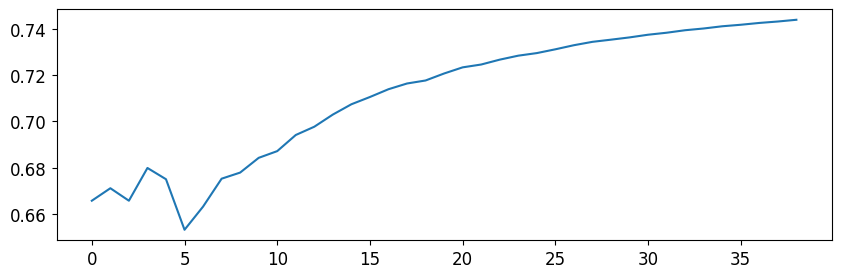

In [145]:
plt.figure(figsize=(10, 3))
acc_arr = np.stack([metrics_history[s]['test_accuracy'] for s in seeds], axis=0)
plt.plot(acc_arr.mean(0))
plt.fill_between(range(acc_arr.shape[1]), acc_arr.mean(0) - acc_arr.std(0),
                 acc_arr.mean(0) + acc_arr.std(0), alpha=0.3)

os.makedirs('data_rew_results', exist_ok=True)
np.save(f'data_rew_results/results_{gamma}.npy', acc_arr)
# np.save(f'data_rew_results/results_drmad.npy', acc_arr)
# np.save(f'data_rew_results/results_IFT_{N}_{K}.npy', acc_arr)
# np.save(f'data_rew_results/results_vanilla.npy', acc_arr)

acc_arr.max(-1)

data_rew_results/results_0.99.npy 76.5 %
data_rew_results/results_IFT_4_2.npy 75.8 %


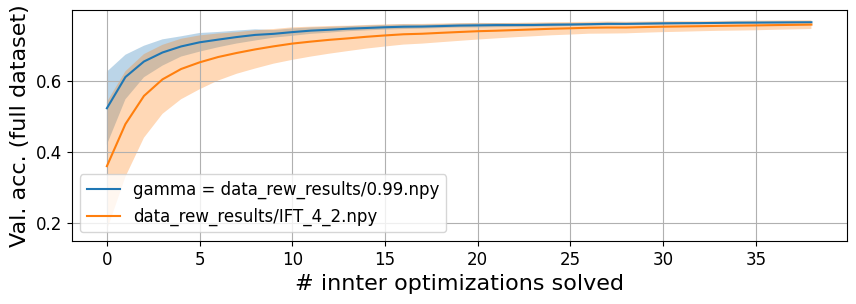

Ttest_indResult(statistic=0.7425229043216679, pvalue=0.4990076971528756)


In [129]:
def get_label(desc_: str):
    desc = desc_.replace('results_', '')
    if 'drmad' in desc:
        return 'DrMAD'
    if 'IFT' in desc:
        return desc
    if 'FISH' in desc:
        return desc
    return f'gamma = {desc}'


plt.figure(figsize=(10, 3))
res = []
for file in glob.glob('data_rew_results/*.npy'):
    m = np.load(file)
    res.append(m.max(-1))
    print(file, round(m.max(-1).mean(), 3) * 100, '%')
    label = get_label(file)
    plt.plot(m.mean(0), label=label)
    plt.fill_between(range(m.shape[1]), m.mean(0) - m.std(0), m.mean(0) + m.std(0), alpha=0.3)    
plt.xlabel('# innter optimizations solved')
plt.ylabel('Val. acc. (full dataset)')
plt.legend()
# plt.savefig('hyper_cleaning.pdf', dpi=200, bbox_inches='tight')
plt.grid()
plt.show()
print(ttest_ind(res[0], res[1]))